# HW 9-1 CNN
---
(慣例的基本套件載入與 MNIST 資料讀取)

In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = len(x_train); n_test = len(x_test)
x_dim= x_test.shape[1]

x_train = x_train.reshape(n_train, x_dim, x_dim, 1)
x_test = x_test.reshape(n_test, x_dim, x_dim, 1)

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

x_train -= x_train.min()
x_train = x_train/x_train.max()

x_test -= x_test.min()
x_test = x_test/x_test.max()

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


## Model 1

先做一個 Sequential 的 CNN

In [2]:
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import concatenate, add
from keras.optimizers import Adadelta, SGD

In [3]:
# Conv 1
model = Sequential([Conv2D(8, (3, 3), padding='same', input_shape=(x_dim, x_dim, 1))])
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(4, 4)))

# Conv 2
model.add(Conv2D(16, (7, 7), padding='same', input_shape=(x_dim, x_dim, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(4, 4)))

# Flatten
model.add(Flatten())
model.add(Dense(81))
model.add(Activation('relu'))

# Output
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          6288      
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 16)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
__________

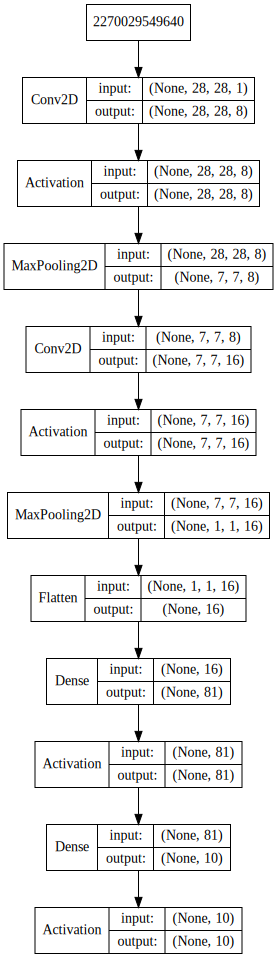

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True,
                 show_layer_names=False).create(prog='dot', format='svg'))

In [5]:
model_fitted = model.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.4982 - acc: 0.8377
Epoch 2/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1427 - acc: 0.9569
Epoch 3/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1119 - acc: 0.9648
Epoch 4/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.0962 - acc: 0.97011s - loss: 0.09
Epoch 5/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.0867 - acc: 0.9728
Epoch 6/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.0792 - acc: 0.9752
Epoch 7/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0729 - acc: 0.9766
Epoch 8/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.0678 - acc: 0.9790
Epoch 9/10
60000/60000 [==============================] - 9s 154us/step - loss: 0.0640 - acc: 0.9801
Epoch 10/10
60000/60000 [==============================] - 11s 189us/step -

In [6]:
score = model.evaluate(x_test,y_test)
print('Accuracy rate of test data: %f'%(score[1]))

10000/10000 [==============================] - 1s 51us/step
Accuracy rate of test data: 0.977700


## Model 2

來個非線性堆疊吧，人有兩隻眼睛，我們的CNN也分兩支：

In [7]:
vis = Input(shape=(x_dim, x_dim, 1))

l1 = Conv2D(2, (3, 3), padding='same', activation='relu')(vis)
l1_pool = MaxPool2D(pool_size=(2, 2))(l1)
l2 = Conv2D(4, (3, 3), padding='same', activation='relu',
            input_shape=(x_dim, x_dim, 1))(l1_pool)
l2_pool = MaxPool2D(pool_size=(2, 2))(l2)
flat = Flatten()(l2_pool)

l1_alt = Conv2D(4, (5, 5), padding='same', activation='relu')(vis)
l1_alt_pool = MaxPool2D(pool_size=(4, 4))(l1_alt)
l2_alt = Conv2D(8, (5, 5), padding='same', activation='relu',
                input_shape=(x_dim, x_dim, 1))(l1_alt_pool)
l2_alt_pool = MaxPool2D(pool_size=(4, 4))(l2_alt)
flat_alt = Flatten()(l2_alt_pool)

flat_com = concatenate([flat, flat_alt])

h1 = Dense(25, activation='relu')(flat_com)
h2 = Dense(25, activation='sigmoid')(flat_com)
h_com = concatenate([h1, h2])
h3 = Dense(16, activation='relu')(h_com)
opt = Dense(10, activation='softmax')(h3)

model2 = Model(inputs=vis, outputs=opt)
model2.compile(loss='categorical_crossentropy',
               optimizer=Adadelta(), metrics=['accuracy'])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 4)    104         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 2)    0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_poolin

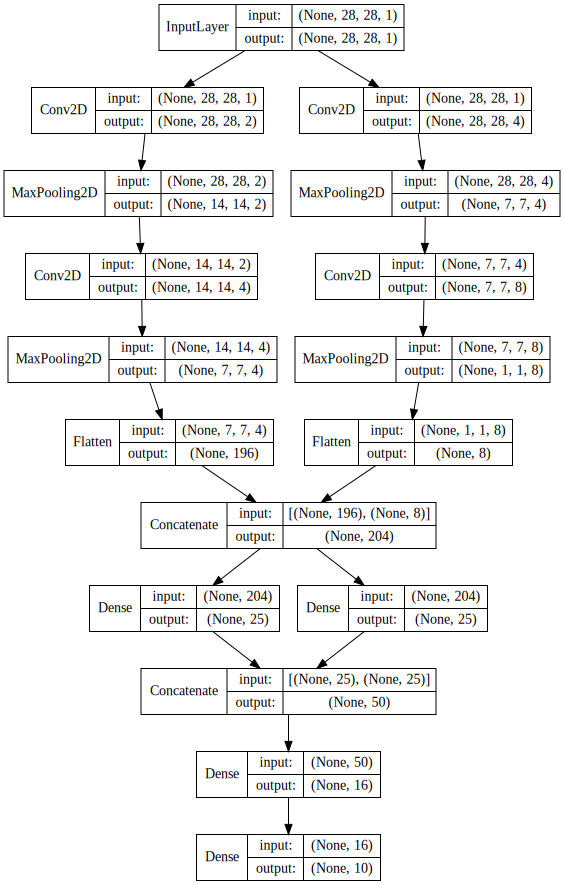

In [8]:
SVG(model_to_dot(model2, show_shapes=True,
                 show_layer_names=False).create(prog='dot', format='svg'))

In [9]:
model2_fitted = model2.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 16s 263us/step - loss: 0.5170 - acc: 0.8376
Epoch 2/10
60000/60000 [==============================] - 16s 262us/step - loss: 0.1632 - acc: 0.9490
Epoch 3/10
60000/60000 [==============================] - 17s 283us/step - loss: 0.1210 - acc: 0.96170s - loss: 0.1214 - acc: 0.9
Epoch 4/10
60000/60000 [==============================] - 14s 240us/step - loss: 0.1020 - acc: 0.9683
Epoch 5/10
60000/60000 [==============================] - 17s 278us/step - loss: 0.0891 - acc: 0.97250s - loss: 0.0889 - acc
Epoch 6/10
60000/60000 [==============================] - 26s 438us/step - loss: 0.0802 - acc: 0.9747
Epoch 7/10
60000/60000 [==============================] - 24s 400us/step - loss: 0.0735 - acc: 0.9771
Epoch 8/10
60000/60000 [==============================] - 21s 347us/step - loss: 0.0678 - acc: 0.9787
Epoch 9/10
60000/60000 [==============================] - 21s 342us/step - loss: 0.0643 - acc: 0.9800
Epoch 10/10
60000/60000 [======

In [10]:
score2 = model2.evaluate(x_test,y_test)
print('Accuracy rate of test data: %f'%(score2[1]))

10000/10000 [==============================] - 12s 1ms/step
Accuracy rate of test data: 0.979700
